# Project 5

## ECE3311 "Principles of Communication Systems" (B-Term 2020)

## Python Scripts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.filters import rcosfilter, rrcosfilter
import scipy.interpolate
import math
import scipy.signal

In [2]:
# Define plotting parameters
pxoffset = 1
pyoffset = 1
pwidth = 7
pheight = 4
smalltxtsize = 12
medtxtsize = 14
bigtxtsize = 18

plt.rc('font', size=smalltxtsize)          # controls default text sizes
plt.rc('axes', titlesize=smalltxtsize)     # fontsize of the axes title
plt.rc('axes', labelsize=medtxtsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=smalltxtsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smalltxtsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=smalltxtsize)    # legend fontsize
plt.rc('figure', titlesize=bigtxtsize)  # fontsize of the figure title

In [3]:
# Equivalent implementation of MATLAB's interp function
def interpolate_1d_vector(vector, factor):
    """
    Interpolate, i.e. upsample, a given 1D vector by a specific interpolation factor.
    :param vector: 1D data vector
    :param factor: factor for interpolation (must be integer)
    :return: interpolated 1D vector by a given factor
    """
    x = np.arange(np.size(vector))
    y = vector
    f = scipy.interpolate.interp1d(x, y, kind='cubic')

    x_extended_by_factor = np.linspace(x[0], x[-1], np.size(x) * factor)
    y_interpolated = np.zeros(np.size(x_extended_by_factor))

    i = 0
    for x in x_extended_by_factor:
        y_interpolated[i] = f(x)
        i += 1

    return y_interpolated

# Section 2: Preparations

In [4]:
# Define simulation parameters to be used in Section 2 and Section 3
N_bits = 10000 # Total number of bits for entire transmission
f_c = 2        # Carrier frequency
f_s = 10       # Sampling frequency
f_d = 1        # Digital system sampling frequency
beta = 0.5     # Roll-off factor for raised cosine filter
sigma_n = 0.25 # Noise standard deviation

In [5]:
# Generate random binary data stream
bin_data = np.around(np.random.random((N_bits,)))

# Assignment of binary sets to amplitude values
bin1 = bin_data # Binary data stream for 2-ASK
bin2 = bin_data.reshape((2,int(N_bits/2))) # Binary data stream for 4-ASK
ampl1 = np.zeros((N_bits,))
ampl2 = np.zeros((int(N_bits/2),))

# Define amplitude mapping for 2-ASK
ampl1[bin1 == 1] = 1
ampl1[bin1 == 0] = -1

# Define amplitude mapping for 4-ASK
ampl2[(bin2[0,:] == 0) & (bin2[1,:] == 0) ] = -3
ampl2[(bin2[0,:] == 1) & (bin2[1,:] == 0) ]  = -1
ampl2[(bin2[0,:] == 0) & (bin2[1,:] == 1) ] = 1
ampl2[(bin2[0,:] == 1) & (bin2[1,:] == 1) ] = 3

In [6]:
# Apply raised cosine pulse shaping filter
ps_rcos = rcosfilter(61,0.5,1,10)[1] # Define raised cosine filter for pulse shaping

# Prepare upsampled and pulse shaped 2-ASK transmission
d_upsample = np.zeros((len(ampl1)*10,))
d_upsample[::10] = ampl1#impulse train

# Prepare upsampled and pulse shaped 4-ASK transmission
d_upsample1 = np.zeros((len(ampl2)*10,))
d_upsample1[::10] = ampl2#impulse train

# Pulse shape both 2-ASK and 4-ASK data streams
ampl1_rcos = np.convolve(ps_rcos,d_upsample,'same')
ampl2_rcos = np.convolve(ps_rcos,d_upsample1,'same')

In [7]:
# Modulate both 2-ASK and 4-ASK pulse shaped signals to carrier frequency f_c
tx_ask2_wavefm = ampl1_rcos*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
tx_ask4_wavefm = ampl2_rcos*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

In [8]:
# Introduce Passband Additive White Gaussian Noise (AWGN) to transmission (both I and Q components)

# AWGN for passband 2-ASK signal
noise_temp = (sigma_n/math.sqrt(2))*np.random.standard_normal(len(tx_ask2_wavefm),) # 
noise2 = noise_temp*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s))) + noise_temp*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))

# AWGN for passband 4-ASK signal
noise_temp1 = (sigma_n/math.sqrt(2))*np.random.standard_normal(len(tx_ask4_wavefm),)
noise4 = noise_temp1*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s))) + noise_temp1*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s))) 

# Noise added, generating passband signals to be intercepted at receiver
rx_ask2_wavefm = tx_ask2_wavefm + noise2
rx_ask4_wavefm = tx_ask4_wavefm + noise4

In [9]:
# Demodulate 2-ASK and 4-ASK waveforms using coherent detection

# Multiple by cosine function with carrier frequency f_c to get I component
ampl1_rawi = rx_ask2_wavefm*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
ampl2_rawi = rx_ask4_wavefm*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

# Multiple by sine function with carrier frequency f_c to get Q component
ampl1_rawq = rx_ask2_wavefm*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
ampl2_rawq = rx_ask4_wavefm*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

# Design lowpass filter and employ it to remove double frequency terms
filt_coeffs = scipy.signal.firwin(61,0.25, window = "hamming", pass_zero = 'lowpass')
ampl1_filti = np.convolve(filt_coeffs,ampl1_rawi,'same')
ampl2_filti = np.convolve(filt_coeffs,ampl2_rawi,'same')
ampl1_filtq = np.convolve(filt_coeffs,ampl1_rawq,'same')
ampl2_filtq = np.convolve(filt_coeffs,ampl2_rawq,'same')

In [10]:
# Sample correct amplitude values from filtered I and Q components
start_samp = int(np.floor((len(rcosfilter(61,0.5,1,10)[1])) + (len(filt_coeffs)-1 )/2)) # Calculate group delay

ampl1_finali = 2*ampl1_filti[start_samp:int(start_samp + (len(ampl1)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl2_finali = 2*ampl2_filti[start_samp:int(start_samp + (len(ampl2)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl1_finalq = 2*ampl1_filtq[start_samp:int(start_samp + (len(ampl1)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl2_finalq = 2.*ampl2_filtq[start_samp:int(start_samp + (len(ampl2)-1)*(f_s/f_d)):int(f_s/f_d]

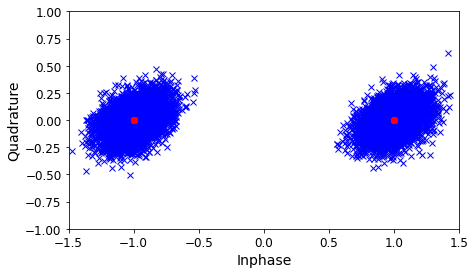

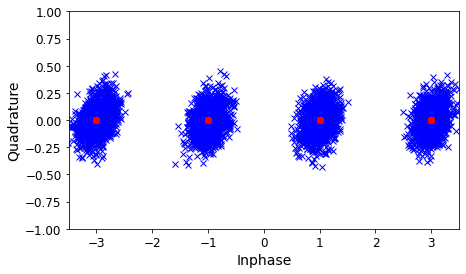

In [11]:
# Generater scatter plots of outputs
plt.figure(figsize=(pwidth,pheight))

plt.plot(ampl1_finali,ampl1_finalq,'bx',ampl1,np.zeros((len(ampl1),)),'ro')
plt.xlim([-1.5,1.5])
plt.ylim([-1,1])
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.savefig('scat2ask.eps', format='eps')
plt.show()

plt.figure(figsize=(pwidth,pheight))
plt.plot(ampl2_finali,ampl2_finalq,'bx',ampl2,np.zeros((len(ampl2),)),'ro')
plt.xlim([-3.5,3.5])
plt.ylim([-1,1])
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.savefig('scat4ask.eps', format='eps')
plt.show()

# Section 3: Two-Dimensional Digital Transmission

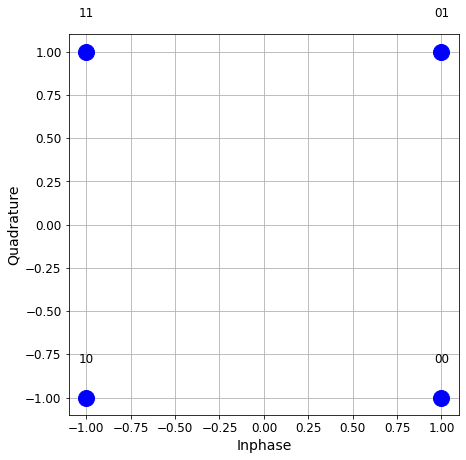

In [12]:
# Example code for mapping two binary digits to a square QAM symbol

# bits per symbol
M = 2  

# Define mapping between binary and I/Q domain
mapping_table = {
    (1,0) : -1-1j,
    (1,1) : -1+1j,
    (0,0) :  1-1j,
    (0,1) :  1+1j
}

# Define corresponding demapping table
demapping_table = {v : k for k, v in mapping_table.items()}

# Plot signal constellation
plt.figure(figsize=(pwidth,pwidth))
for b1 in [0, 1]:
    for b0 in [0, 1]:
        B = (b1, b0)
        Q = mapping_table[B]
        plt.plot(Q.real, Q.imag, 'bo', markersize=16)
        plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.grid()
plt.savefig('sigconstell4qam.eps', format='eps')
plt.show()

# Section 4: Orthogonal Frequency Division Multiplexing

In [13]:
# Define the specifications of the OFDM transceiver
dataCarriers = 52 # Number of data subcarriers
SNR = 8 # Signal-to-Noise Ratio (change this value to see the effect on received signal and constellation)
total_ofdm_symbols = dataCarriers*M  # Total number of bits transmitted per OFDM symbol

# Generate random bits that will form one OFDM symbol
bits = np.random.binomial(n=1, p=0.5, size=(total_ofdm_symbols, ))

# Reshape binary data such that M bits for each of the subcarriers 
def SP(bits):
    return bits.reshape((dataCarriers, M))
bits_SP = SP(bits)

# Map bits to symbols (in this case, these are being mapped to QAM)
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)

In [14]:
# Generate one OFDM symbol using IDFT

# Setup OFDM symbol by initializing with zero vector
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(dataCarriers, dtype=complex) # the overall K subcarriers
    symbol[:] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)

# Apply IDFT to create one OFDM symbol
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)

In [15]:
# Transmit one OFDM symbol across noisy channel
def channel(signal):
    signal_power = np.mean(abs(signal**2))
    sigma2 = signal_power * 10**(-SNR/10)  # calculate noise power based on signal power and SNR
    
    # Print out received signal power and noise power
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*signal.shape)+1j*np.random.randn(*signal.shape))
    return signal + noise

# Pass transmitted OFDM symbol through channel and produce received OFDM symbol   
OFDM_TX = OFDM_time
OFDM_RX = channel(OFDM_TX)

RX Signal power: 0.0385. Noise power: 0.0061


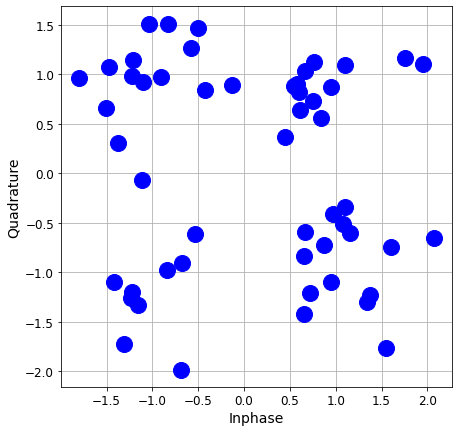

In [16]:
# Apply DFT to received OFDM symbol to recover symbols for each subcarrier
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX)

# Extract subcarrier symbols that formed one OFDM symbol
def get_payload(OFDM_demod):
    return OFDM_demod[:]
QAM_est = get_payload(OFDM_demod)

# Generate scatter plot of each QAM symbol from every subcarrier that formed the single OFDM symbol
plt.figure(figsize=(pwidth,pwidth))
plt.plot(QAM_est.real, QAM_est.imag, 'bo', markersize=16)
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.grid()
plt.savefig('ofdm4qamunmapped.eps', format='eps')
plt.show()

# Section 5: Error Vector Magnitude (EVM) Modulation Detector 

In [17]:
# Use nearest neighbor approach to map received subcarrier symbols to closest possible symbol representation
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

# Perform mapping to closest possible symbol representation
PS_est, hardDecision = Demapping(QAM_est)

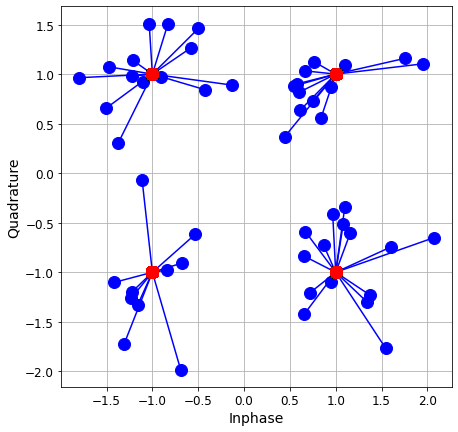

In [18]:
# Plot nearest neighbor mapping process of received subcarrier symbols to closest possible symbol representation
plt.figure(figsize=(pwidth,pwidth))
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o', markersize=12);
    plt.plot(hardDecision.real, hardDecision.imag, 'ro', markersize=12)
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.grid()
plt.savefig('evmofdm.eps', format='eps')
plt.show()

In [19]:
# Generate estimate of original high-speed data stream and calculate bit error rate
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.009615384615384616
